<a href="https://colab.research.google.com/github/tiphtiti/technical-test-2/blob/main/Word_Embeddings_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install transformers datasets accelerate evaluate beautifulsoup4 gensim torchmetrics

In [2]:

from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

<font size="16">Word-Embedding for Sentiment Analysis</font>

# Imdb dataset

## Load dataset

In [3]:
imdb_train = load_dataset("imdb", split="train")
imdb_train = imdb_train.to_pandas()

imdb_test = load_dataset("imdb", split="test")
imdb_test = imdb_test.to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
imdb_train.iloc[1].to_dict()

{'text': '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, 

## Some statistics

In [5]:
imdb_train.head(5)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


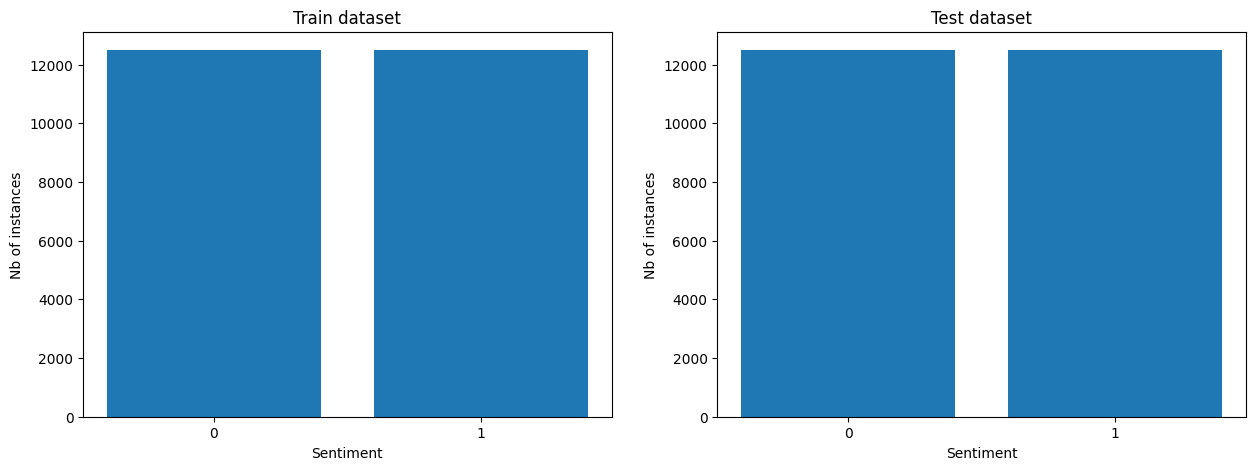

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title("Train dataset")
label_balance = imdb_train["label"].value_counts()
plt.bar(label_balance.index, label_balance)
plt.xticks(ticks=[0, 1], labels=[0, 1])
plt.xlabel("Sentiment")
plt.ylabel("Nb of instances")

plt.subplot(122)
plt.title("Test dataset")
label_balance = imdb_test["label"].value_counts()
plt.bar(label_balance.index, label_balance)
plt.xticks(ticks=[0, 1], labels=[0, 1])
plt.xlabel("Sentiment")
plt.ylabel("Nb of instances")

plt.show()

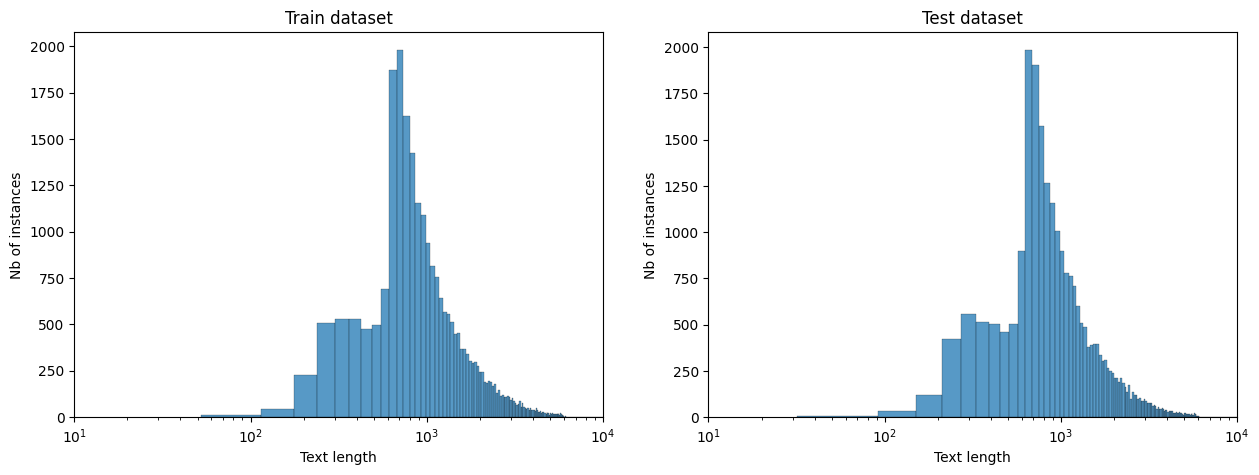

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title("Train dataset")
review_lengths = imdb_train["text"].apply(len)
sns.histplot(x=review_lengths)
plt.xscale("log")
plt.xlim([10, 10000])
plt.xlabel("Text length")
plt.ylabel("Nb of instances")

plt.subplot(122)
plt.title("Test dataset")
review_lengths = imdb_test["text"].apply(len)
sns.histplot(x=review_lengths)
plt.xscale("log")
plt.xlim([10, 10000])
plt.xlabel("Text length")
plt.ylabel("Nb of instances")

plt.show()

# 0 Bag-of-Words

# Generate features

In [8]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(imdb_train["text"]);

In [24]:
X_train, y_train = vectorizer.transform(imdb_train["text"]), imdb_train["label"]
X_test, y_test = vectorizer.transform(imdb_test["text"]), imdb_test["label"]

AttributeError: 'list' object has no attribute 'lower'

# Train model

In [18]:
classifier = LinearSVC(random_state=42, max_iter=10000)

In [19]:
classifier.fit(X_train, y_train);

In [20]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [21]:
print('Train dataset')
print(classification_report(y_train, y_pred_train))

print('Test dataset')
print(classification_report(y_test, y_pred_test))

Train dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12500
           1       1.00      1.00      1.00     12500

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000

Test dataset
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## Preprocessing the text

In [26]:
import gensim
from sklearn.model_selection import train_test_split

In [23]:
imdb_train["text"] = imdb_train["text"].apply(lambda x: gensim.utils.simple_preprocess(x))
imdb_train.head()

,text,label
0,"[rented, am, curious, yellow, from, my, video,...",0
1,"[am, curious, yellow, is, risible, and, preten...",0
2,"[if, only, to, avoid, making, this, type, of, ...",0
3,"[this, film, was, probably, inspired, by, goda...",0
4,"[oh, brother, after, hearing, about, this, rid...",0


In [34]:
X_train, X_test, y_train, y_test = train_test_split (imdb_train['text'], imdb_train['label'] , test_size=0.5)

In [35]:
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [38]:
w2v_model.wv.index_to_key

['the',
 'and',
 'of',
 'to',
 'is',
 'br',
 'it',
 'in',
 'this',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'you',
 'on',
 'not',
 'he',
 'are',
 'his',
 'have',
 'one',
 'be',
 'all',
 'at',
 'they',
 'by',
 'an',
 'who',
 'so',
 'from',
 'like',
 'her',
 'there',
 'or',
 'just',
 'about',
 'out',
 'has',
 'if',
 'what',
 'some',
 'good',
 'can',
 'she',
 'when',
 'more',
 'very',
 'up',
 'even',
 'time',
 'my',
 'would',
 'no',
 'which',
 'story',
 'only',
 'really',
 'their',
 'see',
 'had',
 'we',
 'well',
 'me',
 'were',
 'than',
 'much',
 'people',
 'other',
 'get',
 'been',
 'great',
 'into',
 'will',
 'also',
 'do',
 'bad',
 'first',
 'because',
 'most',
 'don',
 'him',
 'how',
 'made',
 'its',
 'make',
 'then',
 'them',
 'way',
 'could',
 'too',
 'after',
 'any',
 'movies',
 'think',
 'characters',
 'two',
 'character',
 'watch',
 'films',
 'life',
 'many',
 'being',
 'seen',
 'plot',
 'little',
 'never',
 'acting',
 'love',
 'show',
 'where',
 'bes

In [36]:
w2v_model.wv.most_similar('adventure')

[('fantasy', 0.7905325293540955),
 ('drama', 0.7753112316131592),
 ('thriller', 0.7619193196296692),
 ('western', 0.7476741671562195),
 ('epic', 0.7396809458732605),
 ('parody', 0.7326099276542664),
 ('italian', 0.7256408929824829),
 ('anthology', 0.7255152463912964),
 ('indie', 0.7226781249046326),
 ('achievement', 0.718769907951355)]

In [41]:
import numpy as np

def average_word_vectors(text, model, vocabulary):
    """Averages the word vectors for a given text."""
    word_vectors = [model.wv[word] for word in text if word in vocabulary]
    if word_vectors:  # Check if any word vectors were found
        return np.mean(word_vectors, axis=0)  # Average the vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words found


In [42]:
# Assuming 'X_train', 'X_test', 'w2v_model', and 'words' are already defined
words = set(w2v_model.wv.index_to_key)

# Convert text data to average word vectors
X_train_vect = np.array([average_word_vectors(doc, w2v_model, words) for doc in X_train])
X_test_vect = np.array([average_word_vectors(doc, w2v_model, words) for doc in X_test])

In [43]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [45]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), v.shape[0] if v.ndim > 0 else 1)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
447 1
459 1
216 1
231 1
323 1
266 1
148 1
431 1
135 1
157 1
314 1
138 1
90 1
139 1
182 1
279 1
153 1
123 1
225 1
104 1
249 1
368 1
63 1
71 1
73 1
150 1
203 1
138 1
110 1
91 1
56 1
450 1
267 1
283 1
118 1
748 1
406 1
250 1
172 1
313 1
170 1
74 1
64 1
110 1
107 1
53 1
201 1
174 1
253 1
176 1
580 1
154 1
710 1
221 1
115 1
157 1
119 1
362 1
492 1
125 1
134 1
346 1
113 1
141 1
186 1
118 1
228 1
178 1
100 1
112 1
134 1
221 1
211 1
245 1
84 1
237 1
163 1
194 1
203 1
513 1
573 1
181 1
71 1
24 1
125 1
406 1
142 1
231 1
125 1
173 1
297 1
178 1
280 1
205 1
159 1
351 1
148 1
110 1
141 1
365 1
119 1
310 1
176 1
211 1
175 1
137 1
316 1
563 1
129 1
123 1
121 1
48 1
146 1
171 1
164 1
164 1
105 1
85 1
395 1
106 1
179 1
116 1
221 1
218 1
239 1
139 1
126 1
180 1
212 1
292 1
158 1
58 1
151 1
93 1
138 1
151 1
163 1
175 1
152 1
53 1
126 1
220 1
86 1
117 1
210 1
122 1
119 1
126 1
98 1
113 1
152 1
402 1
122 1
325 1
340 1
108 1
45 1


In [47]:
# Convert X_train_vect_avg and X_test_vect_avg to NumPy arrays
X_train_vect_avg = np.array(X_train_vect_avg)
X_test_vect_avg = np.array(X_test_vect_avg)

# Reshape to 2D if necessary
if X_train_vect_avg.ndim == 1:
    X_train_vect_avg = X_train_vect_avg.reshape(-1, 1)
if X_test_vect_avg.ndim == 1:
    X_test_vect_avg = X_test_vect_avg.reshape(-1, 1)

# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [48]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [49]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.505 / Recall: 0.513 / Accuracy: 0.508


# Pretrained model

In [50]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [51]:
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples=1, epochs=1)
(0, 2)

(0, 2)

In [52]:
vector = model.wv['computer']  # get numpy vector of a word
sims = model.wv.most_similar('computer', topn=10)  # get other similar words

In [53]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['computer']  # Get numpy vector of a word

In [55]:
from gensim.test.utils import datapath

# Load a word2vec model stored in the C *text* format.
wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)
# Load a word2vec model stored in the C *binary* format.
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("euclidean_vectors.bin"), binary=True)

In [ ]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))
['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-25')

# Use the downloaded vectors as usual:
glove_vectors.most_similar('twitter')
[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104824066162109),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885937333106995),
 ('tweets', 0.8878158330917358),
 ('tl', 0.8778461217880249),
 ('link', 0.8778210878372192),
 ('internet', 0.8753897547721863)]

Avec google

In [56]:
from datasets import load_dataset
import pandas as pd
import gensim.downloader as api

# Charger les données IMDB
imdb_train = load_dataset("imdb", split="train")
imdb_train = imdb_train.to_pandas()

imdb_test = load_dataset("imdb", split="test")
imdb_test = imdb_test.to_pandas()

# Charger les embeddings Word2Vec pré-entraînés
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [57]:
import numpy as np

def text_to_vector(text, model):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Appliquer la fonction aux données d'entraînement et de test
imdb_train['vector'] = imdb_train['text'].apply(lambda x: text_to_vector(x, word2vec_model))
imdb_test['vector'] = imdb_test['text'].apply(lambda x: text_to_vector(x, word2vec_model))

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparer les caractéristiques et les étiquettes
X_train = np.stack(imdb_train['vector'].values)
y_train = imdb_train['label'].values

X_test = np.stack(imdb_test['vector'].values)
y_test = imdb_test['label'].values

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Entraîner le modèle
model = LinearSVC()
model.fit(X_train, y_train)

# Faire des prédictions
y_pred = model.predict(X_test)
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Évaluer le modèle
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.843 / Recall: 0.838 / Accuracy: 0.841


# BERT

In [62]:
pip install transformers datasets evaluate accelerate

In [63]:
from datasets import load_dataset

imdb = load_dataset("imdb")

In [64]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [65]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [66]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [67]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [68]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [69]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [70]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.131900,0.259493
